# $$ ANKIT\ KUMAR\ ME20B024 $$

# 1.a)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade

In [2]:
tf.keras.backend.set_floatx("float64")

### creating data 

In [8]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

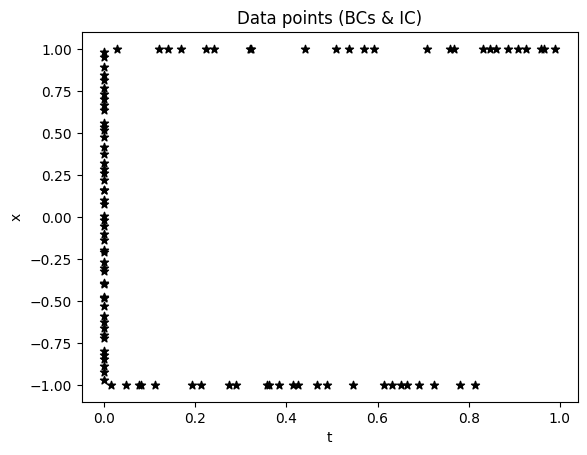

In [9]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="*", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [7]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [8]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

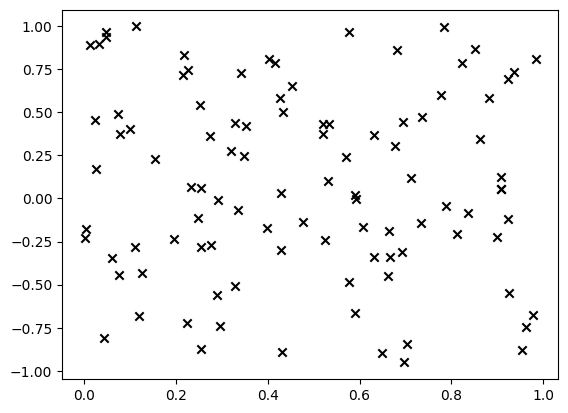

In [17]:
import matplotlib.pyplot as plt
plt.scatter(t_c[0:100] , x_c[0:100] , marker="x", c="k")

In [9]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [2]:
### model design
import tensorflow as tf
neuron_per_layer = 20
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [66]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [67]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    F = u_t + (0.01/np.pi)*u_x
    return tf.reduce_mean(tf.square(F))

In [165]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [69]:
import time

In [70]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 1000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points # boundary loss
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

epoch -    0 /1000 : 0.298
epoch -   10 /1000 : 0.206
epoch -   20 /1000 : 0.195
epoch -   30 /1000 : 0.191
epoch -   40 /1000 : 0.187
epoch -   50 /1000 : 0.181
epoch -   60 /1000 : 0.172
epoch -   70 /1000 : 0.159
epoch -   80 /1000 : 0.141
epoch -   90 /1000 : 0.119
epoch -  100 /1000 : 0.096
epoch -  110 /1000 : 0.073
epoch -  120 /1000 : 0.047
epoch -  130 /1000 : 0.028
epoch -  140 /1000 : 0.017
epoch -  150 /1000 : 0.010
epoch -  160 /1000 : 0.007
epoch -  170 /1000 : 0.005
epoch -  180 /1000 : 0.004
epoch -  190 /1000 : 0.003
epoch -  200 /1000 : 0.003
epoch -  210 /1000 : 0.002
epoch -  220 /1000 : 0.002
epoch -  230 /1000 : 0.002
epoch -  240 /1000 : 0.002
epoch -  250 /1000 : 0.001
epoch -  260 /1000 : 0.002
epoch -  270 /1000 : 0.001
epoch -  280 /1000 : 0.001
epoch -  290 /1000 : 0.001
epoch -  300 /1000 : 0.001
epoch -  310 /1000 : 0.001
epoch -  320 /1000 : 0.001
epoch -  330 /1000 : 0.001
epoch -  340 /1000 : 0.001
epoch -  350 /1000 : 0.001
epoch -  360 /1000 : 0.001
e

Text(0.5, 0, 'epoch')

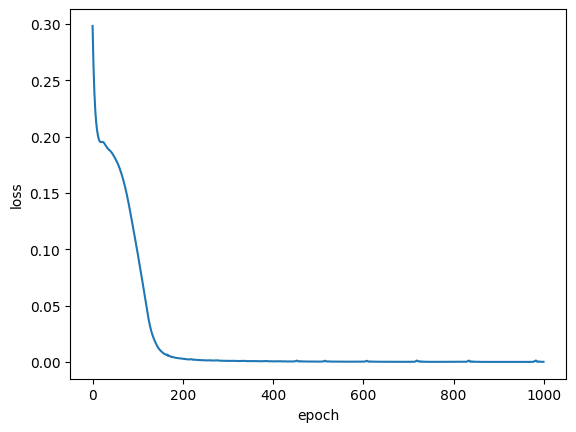

In [71]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

## Predicted solution 

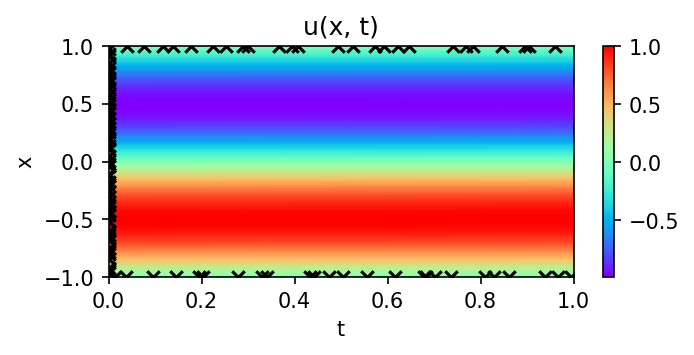

In [72]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

63/63 [==============================] - 0s 2ms/step


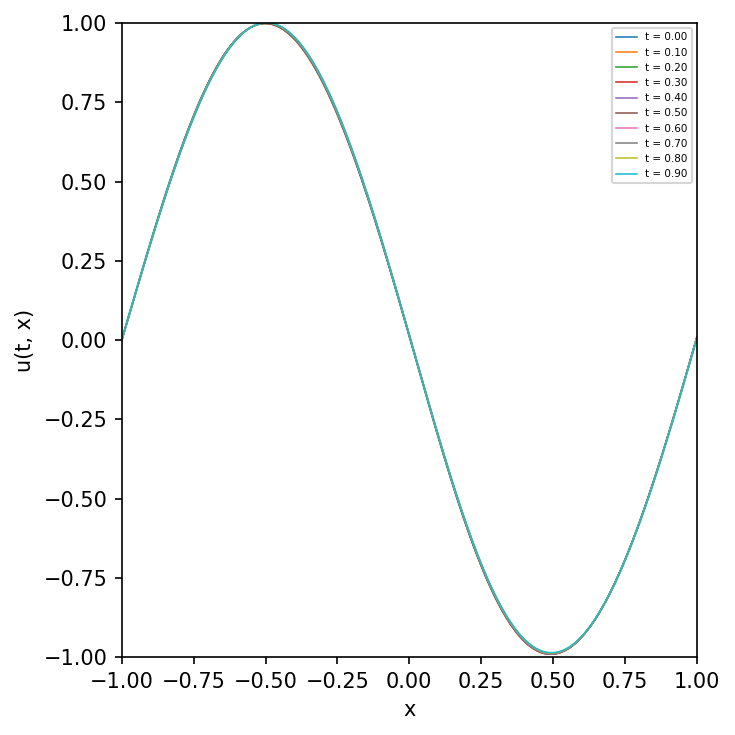

In [74]:


plt.figure(figsize=(5, 5), dpi=150)
# input shape
n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], model.predict(v), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.savefig("u-constant-time.png")
plt.show()

# 1.a) Analytical solution

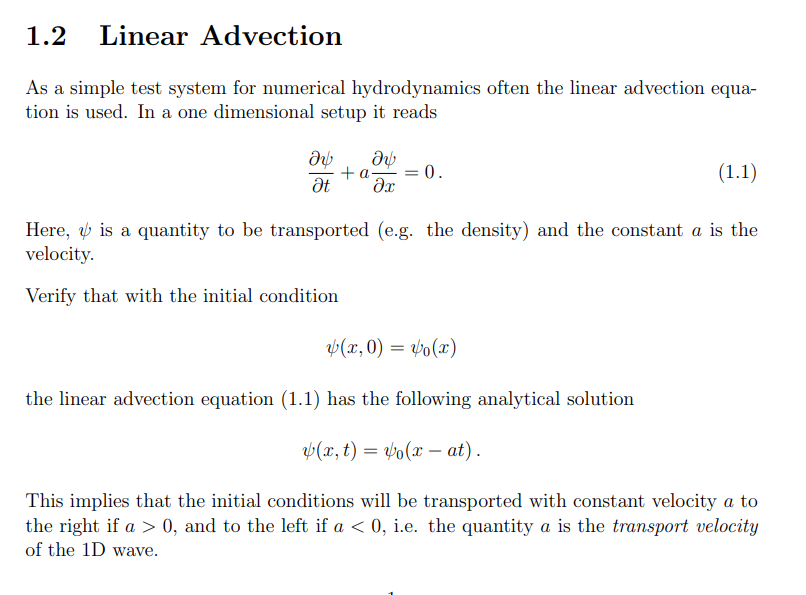

In [97]:
import math
def U_analytical(X,T):
  a = 0.01/np.pi
  X = np.array(X)
  T = np.array(T)
  # U_ana = np.sin(np.pi*X)*(X + a*T)    # taking Ψo = -math.sin(math.pi*x)
  U_ana = -np.sin(np.pi*(X - a*T))  
  return U_ana

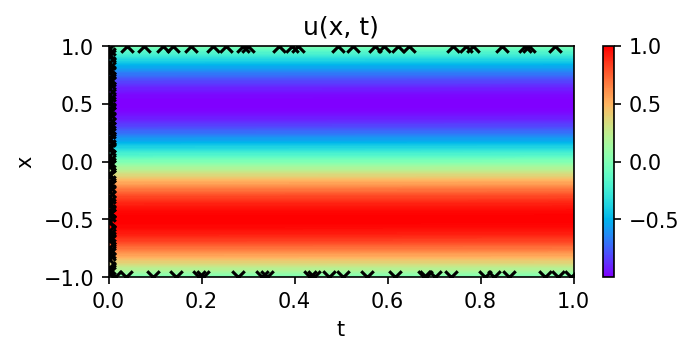

In [98]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
# X = tf.convert_to_tensor(X)
# T = tf.convert_to_tensor(T)
# X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = U_analytical(X,T)
S = S.reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

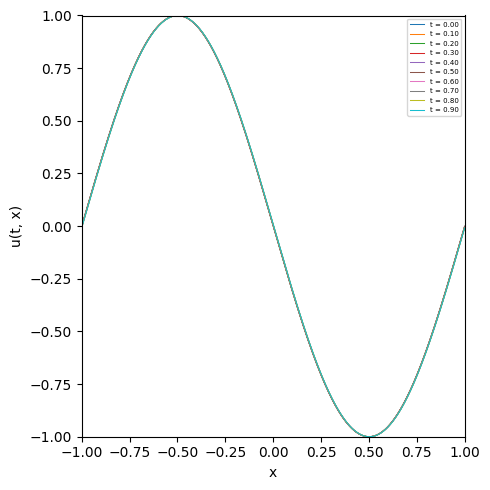

In [100]:
# make a function `u(t, x)` to use model easier
u = lambda t, x: U_analytical(x,t)

plt.figure(figsize=(5, 5), dpi=100)
# input shape
n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], U_analytical(v[:,1],v[:,0]), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

## Comparison between analytical and PINNs solution

In [107]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)




63/63 [==============================] - 0s 2ms/step


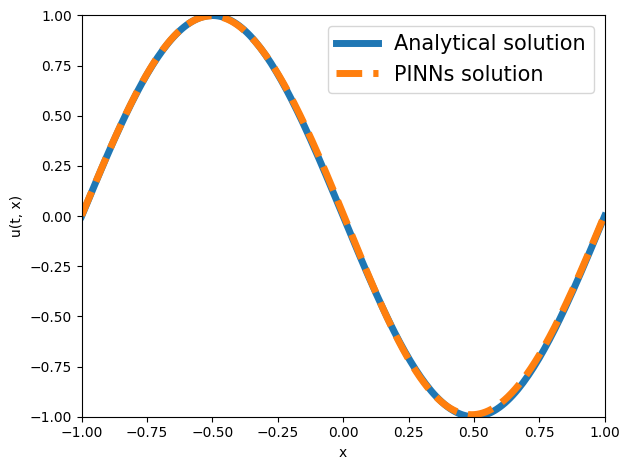

In [116]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)

plt.plot(X , S  , label = "Analytical solution" , lw = 5)

n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
v[:, 0] = 0
plt.plot(v[:, 1], model.predict(v), label="PINNs solution", lw=5 , linestyle='--')
plt.legend(loc="upper right", fontsize=15)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

### we can see that exact and solution predicted by PINNs are almost same

# Question - 2

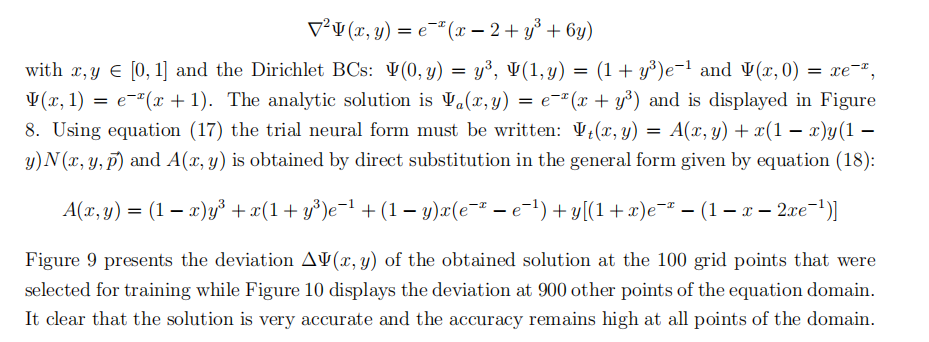

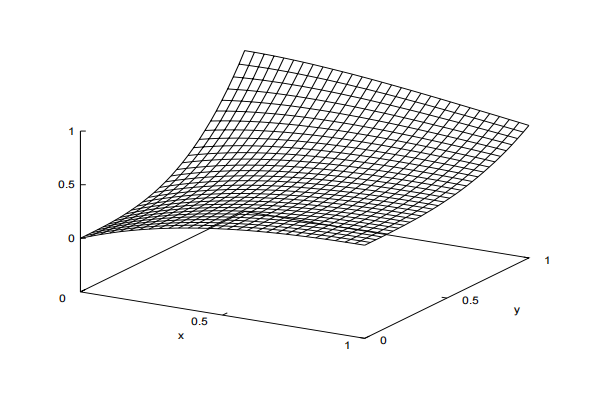


In [3]:
### model design
import tensorflow as tf
# input layer
input_layer = tf.keras.layers.Input(shape=(2,))
# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(10, activation="tanh")(input_layer)
# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden0)

model_lagg = tf.keras.Model(input_layer, output_layer)

model_lagg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 10)                30        
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [58]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(x, y):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model_lagg(tf.concat([x, y], axis=1)) # note the axis ; `column`
    return u

# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(x, y):

    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]
    
    e = tf.exp( tf.cast(tf.constant(1.0), tf.float64))
    e_ = tf.exp(tf.cast(tf.constant(-1.0), tf.float64))

    # A = (1 - x)*y**3 + x*(1 + y**3)*e**(-1) + (1 - y)*x*(e**(-x) - e**(-1)) + y*((1 + x)*e**(-x) - (1 - x - 2*x*e**(-1)))
 
    A = (1 - x)*tf.math.pow(y, 3) + x*(1 + tf.math.pow(y, 3))*e_ + (1 - y)*x*(tf.exp(-x) - e_) + y*((1 + x)*tf.exp(-x) - (1 - x - 2*x*e_))
    N = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)
    F = A + x*(1 - x)*y*(1 - y)*N

    return tf.reduce_mean(tf.square(F))

### Creating Data 

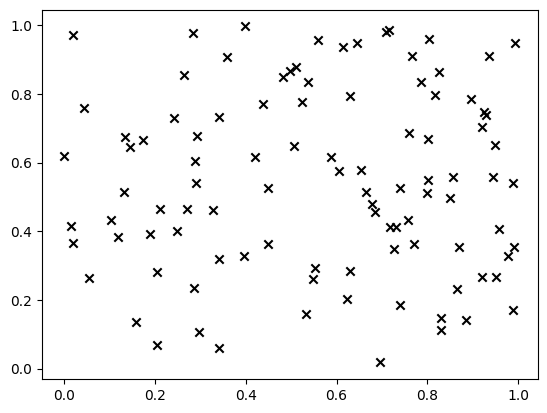

In [4]:
from matplotlib import cm
import numpy as np
from scipy.stats import qmc

# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)



# change names
x_c = np.expand_dims(data[:, 0], axis=1)
y_c = np.expand_dims(data[:, 1], axis=1)

import matplotlib.pyplot as plt
plt.scatter(x_c[0:100] , y_c[0:100] , marker="x", c="k")

In [5]:
# convert all data and collocation points to tf.Tensor
x_c, y_c = map(tf.convert_to_tensor, [ x_c, y_c])

In [59]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 25000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        # physics-informed loss for collocation points
        L1 = f(x_c, y_c)

        loss = L1 
    # compute gradients
    g = tape.gradient(loss, model_lagg.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model_lagg.trainable_weights))



epoch -    0 /25000 : 0.792
epoch -   10 /25000 : 0.790
epoch -   20 /25000 : 0.788
epoch -   30 /25000 : 0.786
epoch -   40 /25000 : 0.784
epoch -   50 /25000 : 0.781
epoch -   60 /25000 : 0.779
epoch -   70 /25000 : 0.777
epoch -   80 /25000 : 0.774
epoch -   90 /25000 : 0.772
epoch -  100 /25000 : 0.770
epoch -  110 /25000 : 0.767
epoch -  120 /25000 : 0.764
epoch -  130 /25000 : 0.762
epoch -  140 /25000 : 0.759
epoch -  150 /25000 : 0.756
epoch -  160 /25000 : 0.754
epoch -  170 /25000 : 0.751
epoch -  180 /25000 : 0.748
epoch -  190 /25000 : 0.745
epoch -  200 /25000 : 0.742
epoch -  210 /25000 : 0.739
epoch -  220 /25000 : 0.736
epoch -  230 /25000 : 0.733
epoch -  240 /25000 : 0.730
epoch -  250 /25000 : 0.726
epoch -  260 /25000 : 0.723
epoch -  270 /25000 : 0.720
epoch -  280 /25000 : 0.717
epoch -  290 /25000 : 0.713
epoch -  300 /25000 : 0.710
epoch -  310 /25000 : 0.706
epoch -  320 /25000 : 0.703
epoch -  330 /25000 : 0.699
epoch -  340 /25000 : 0.696
epoch -  350 /25000 

Text(0.5, 0, 'epoch')

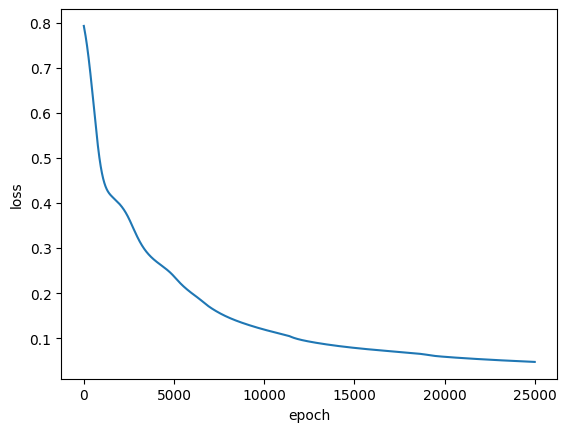

In [60]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

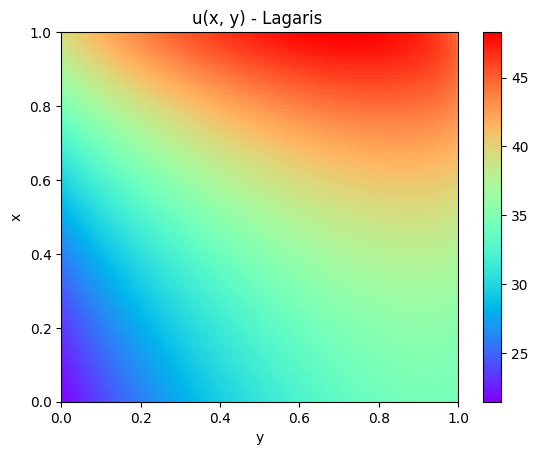

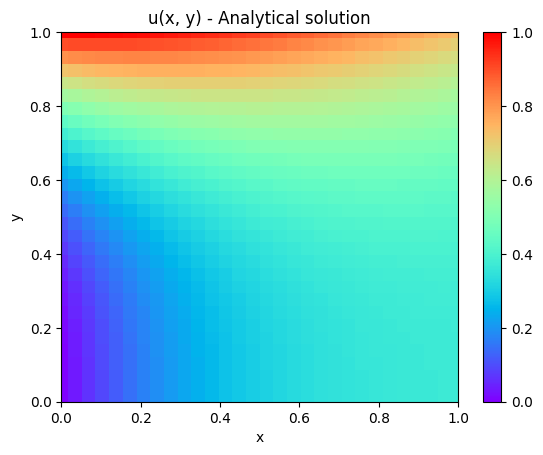

In [64]:
### plot
# another code is also available for ploting
n, m = 100, 100
X = np.linspace(0, +1, m)
Y = np.linspace(0, 1, n)
X0, Y0 = np.meshgrid(X, Y)
X1 = X0.reshape([n*m, 1])
Y1 = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
Y = tf.convert_to_tensor(Y1)
S1 = u(X , Y)
S = S1.numpy().reshape(m, n)
plt.pcolormesh( X0, Y0 , S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Lagaris ")
plt.ylabel("x")
plt.xlabel("y")
plt.show()



## Plotting Analytical solution
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

plt.pcolormesh(X, Y, Z, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Analytical solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

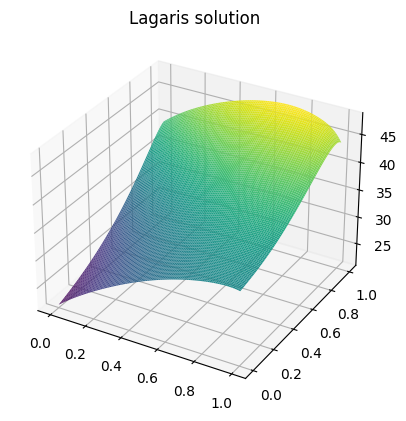

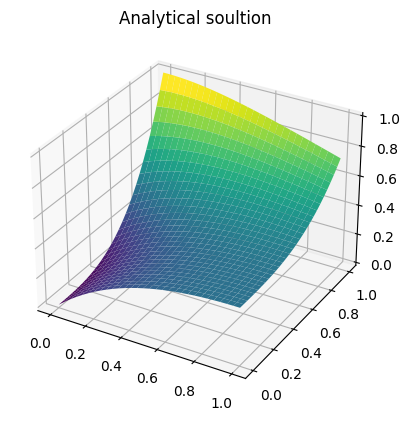

In [66]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_surface(X0, Y0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Lagaris solution');
plt.show()

## Analytical solution 

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Analytical soultion');

# 2.b) Using PINNS

In [5]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
y_d = engine.random(n=number_of_ic_points)
temp1 = np.zeros([number_of_bc1_points, 1]) # for IC ; y = 0
temp2 = np.ones([number_of_bc2_points, 1]) # for IC ; y = 1
y_d = np.append( temp1 , y_d, axis=0)
y_d = np.append( temp2, y_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
# x_d = 2 * (x_d - 0.5)
temp1 = np.zeros([number_of_bc1_points, 1]) # for BC1 ; x = 0
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

In [6]:
import pandas as pd
pd.DataFrame({  "x_d": x_d.reshape((100,)), "y_d": y_d.reshape((100,)) })


,x_d,y_d
0,0.792891,1.000000
1,0.143639,1.000000
2,0.778484,1.000000
3,0.319082,1.000000
4,0.110166,1.000000
...,...,...
95,1.000000,0.154340
96,1.000000,0.221124
97,1.000000,0.582640
98,1.000000,0.931671


In [135]:
t_d.shape , x_d.shape

((100, 1), (100, 1))

Text(0.5, 1.0, 'Data points (BCs & IC)')

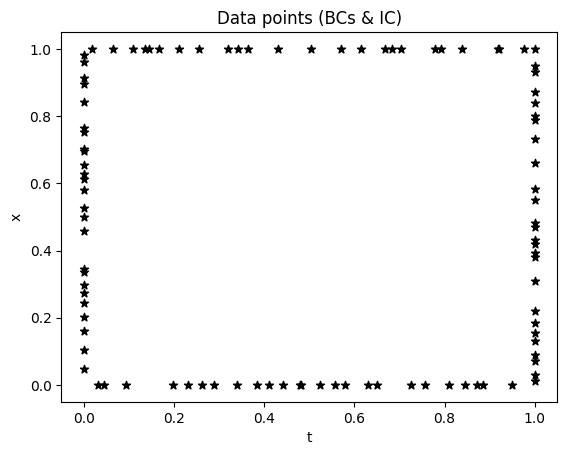

In [7]:
# view randomly sampled boundary and initial points
plt.scatter(x_d, y_d, marker="*", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [9]:
# output values for data points (boundary and initial)
z_d = np.zeros(x_d.shape)

# Ψ(0, y) = y3 , Ψ(1, y) = (1 + y3)e−1 and Ψ(x, 0) = xe−x, Ψ(x, 1) = e−x(x + 1).
# for initial condition:  y =1 
z_d[ : 25] = np.exp(-x_d[:25])*(x_d[:25] + 1)

# Boundary condition : y = 0
z_d[25 : 50] = x_d[25: 50]*np.exp(-x_d[25 : 50])

# Boundary condition : x = 0
z_d[ 50 : 75] = np.power(y_d[ 50 : 75] , 3)

# Boundary condition : x = 1
z_d[75:100] = (1 + np.power(y_d[ 75 : 100] , 3))*np.exp(-1)

In [10]:
# convert all data and collocation points to tf.Tensor
x_d, y_d, z_d, x_c, y_c = map(tf.convert_to_tensor, [x_d, y_d, z_d, x_c, y_c])

In [11]:
x_d.dtype , y_d.dtype , z_d.dtype , x_c.dtype , y_c.dtype

(tf.float64, tf.float64, tf.float64, tf.float64, tf.float64)

In [33]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))



# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

@tf.function
def f(x, y):

    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]


    F = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)


    return tf.reduce_mean(tf.square(F))




In [34]:


epochs = 1000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u( x_d , y_d)
        y_ = tf.cast(y_, tf.float64)
        # physics-informed loss for collocation points
        L1 = f(x_c , y_c)
        # MSE loss for data points # boundary loss
        L2 = mse(z_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))



epoch -    0 /1500 : 3.292
epoch -   10 /1500 : 2.569
epoch -   20 /1500 : 1.988
epoch -   30 /1500 : 1.427
epoch -   40 /1500 : 0.872
epoch -   50 /1500 : 0.681
epoch -   60 /1500 : 0.509
epoch -   70 /1500 : 0.388
epoch -   80 /1500 : 0.298
epoch -   90 /1500 : 0.216
epoch -  100 /1500 : 0.153
epoch -  110 /1500 : 0.112
epoch -  120 /1500 : 0.084
epoch -  130 /1500 : 0.066
epoch -  140 /1500 : 0.053
epoch -  150 /1500 : 0.044
epoch -  160 /1500 : 0.037
epoch -  170 /1500 : 0.032
epoch -  180 /1500 : 0.029
epoch -  190 /1500 : 0.026
epoch -  200 /1500 : 0.024
epoch -  210 /1500 : 0.022
epoch -  220 /1500 : 0.020
epoch -  230 /1500 : 0.018
epoch -  240 /1500 : 0.017
epoch -  250 /1500 : 0.015
epoch -  260 /1500 : 0.014
epoch -  270 /1500 : 0.013
epoch -  280 /1500 : 0.011
epoch -  290 /1500 : 0.010
epoch -  300 /1500 : 0.010
epoch -  310 /1500 : 0.009
epoch -  320 /1500 : 0.008
epoch -  330 /1500 : 0.008
epoch -  340 /1500 : 0.007
epoch -  350 /1500 : 0.007
epoch -  360 /1500 : 0.007
e

Text(0.5, 0, 'epoch')

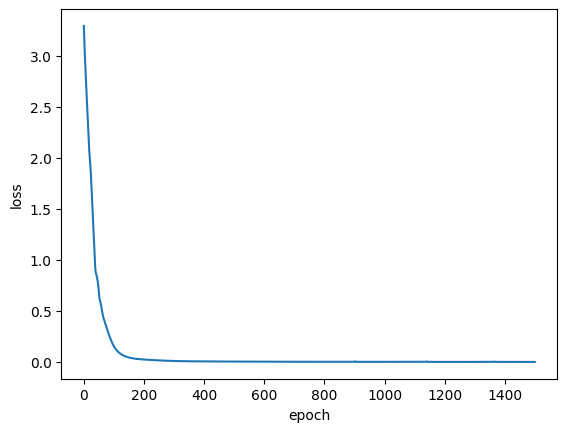

In [37]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

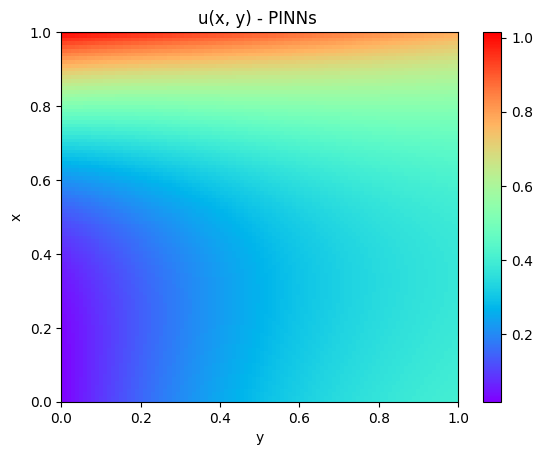

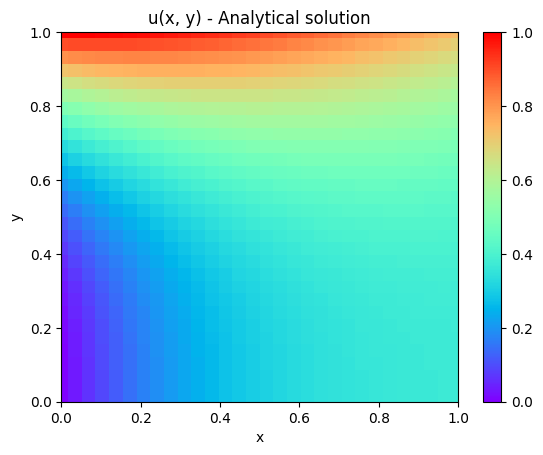

In [35]:
### plot
# another code is also available for ploting
n, m = 100, 100
X = np.linspace(0, +1, m)
Y = np.linspace(0, 1, n)
X0, Y0 = np.meshgrid(X, Y)
X1 = X0.reshape([n*m, 1])
Y1 = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
Y = tf.convert_to_tensor(Y1)
S1 = u(X , Y)
S = S1.numpy().reshape(m, n)
plt.pcolormesh( X0, Y0 , S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - PINNs ")
plt.ylabel("x")
plt.xlabel("y")
plt.show()



## Plotting Analytical solution
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

plt.pcolormesh(X, Y, Z, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Analytical solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

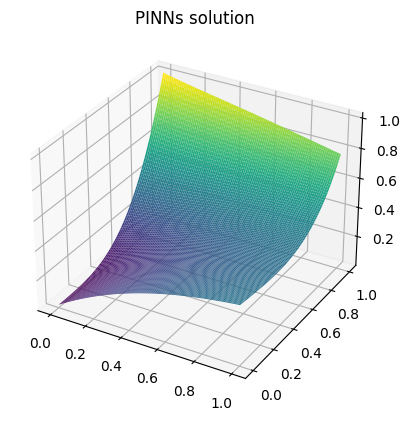

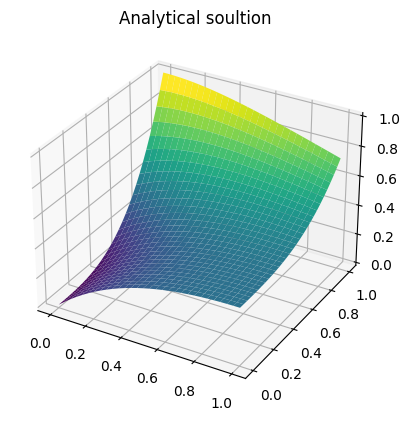

In [36]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_surface(X0, Y0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('PINNs solution');
plt.show()

## Analytical solution 

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Analytical soultion');

### In Lagaris method we are not getting exact solution equal to analytical , becuase our loss function is not convering to 0 , this is be becuase we are using only one layer with 10 neurons.

### while , PINNs are able to exact solution similar to analytics , this is becuase we are using full connect deep neural network with 8 layers and 20 neurons in each layer.